In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

!pip install metric-learn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import h5py

houston18_file = h5py.File('/content/drive/MyDrive/proje/Houston18.mat', 'r')
houston18_gt_file = h5py.File('/content/drive/MyDrive/proje/Houston18_7gt.mat', 'r')

data = np.array(houston18_file['ori_data'])
gt = np.array(houston18_gt_file['map'])


def applyPCA(X, numComponents=15):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX


data = np.transpose(data, (1, 2, 0))

data=applyPCA(data)

df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))
df['class'] = gt.ravel()

X = df[df['class']!=0].iloc[:, :-1].values

y = df[df['class']!=0].iloc[:, -1].values



In [5]:
from sklearn.neighbors import KNeighborsClassifier
from metric_learn import MLKR

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

mlkr = MLKR(verbose=True, max_iter=100)
knn = KNeighborsClassifier(n_neighbors=5)

# MLKR modelini eğitim verilerine uygula
mlkr.fit(X_train, y_train)

# KNN modelini MLKR dönüştürülmüş eğitim verilerine uygula
knn.fit(mlkr.transform(X_train), y_train)

# Modeli test verileri üzerinde değerlendir
mlkr_acc = knn.score(mlkr.transform(X_test), y_test)
print('MLKR accuracy:', mlkr_acc)

[MLKR]
[MLKR]  Iteration      Objective Value    Time(s)
[MLKR] ------------------------------------------
[MLKR]          0         6.255274e+03      31.08
[MLKR]          1         4.950997e+03      31.06
[MLKR]          2         4.400965e+03      31.28
[MLKR]          3         3.526594e+03      33.17
[MLKR]          4         3.402007e+03      36.65
[MLKR]          5         3.186840e+03      37.14
[MLKR]          6         3.053096e+03      37.46
[MLKR]          7         3.058568e+03      37.92
[MLKR]          8         2.997263e+03      37.55
[MLKR]          9         2.937906e+03      38.37
[MLKR]         10         2.894349e+03      40.47
[MLKR]         11         2.819807e+03      41.38
[MLKR]         12         2.767269e+03      42.37
[MLKR]         13         2.717794e+03      43.45
[MLKR]         14         2.683339e+03      44.30
[MLKR]         15         2.662284e+03      44.42
[MLKR]         16         2.638357e+03      44.59
[MLKR]         17         2.619323e+03     

# **Görselleştirme**

In [8]:
import joblib

joblib.dump(mlkr, 'mlkr_houston_model.pkl')
joblib.dump(knn,'mlkr_houston_knn_model.pkl')

mlkr_loaded = joblib.load('mlkr_houston_model.pkl')
knn_loaded =joblib.load('mlkr_houston_knn_model.pkl')

mlkr_data=mlkr_loaded.transform(X)
pred=knn_loaded.predict(mlkr_data)

In [9]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

print("accuracy:",accuracy_score(pred,y))
print("cohen kappa:", cohen_kappa_score(pred,y))
print("f1 score:",f1_score(pred,y,average='macro'))

accuracy: 0.9518233082706767
cohen kappa: 0.9187658433567014
f1 score: 0.9252227851668792


In [10]:
gt_2 = gt.copy()
gt_2=gt_2.reshape(-1)


i = 0
j=0
while(i<(gt.shape[0]*gt.shape[1])):
      if(gt_2[i] != 0):
          gt_2[i]=pred[j]
          j += 1
      i += 1

In [11]:
gt_2=gt_2.reshape(data.shape[0],-1)

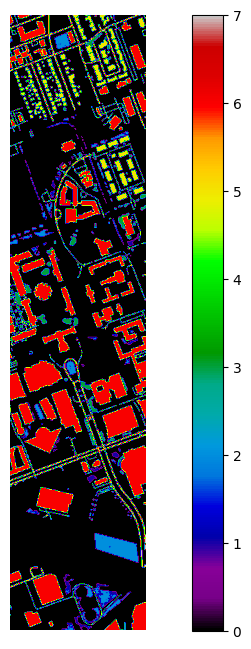

In [12]:
def plot_gt(data):
  fig = plt.figure(figsize=(12, 8))
  plt.imshow(data,cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

plot_gt(gt)

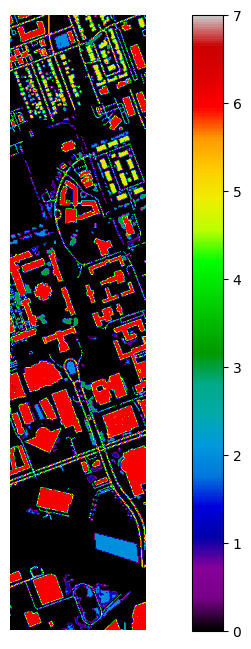

In [13]:
plot_gt(gt_2)